In [22]:
import pandas as pd
import os
PATH = './santa-workshop-tour-2019/'

# Data Exploration

In [23]:
family_data = pd.read_csv(PATH+'family_data.csv')
family_data.head()

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4


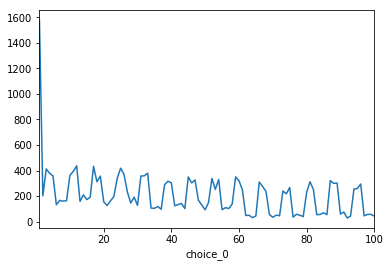

In [24]:
family_data.groupby(['choice_0']).sum()['n_people'].plot()

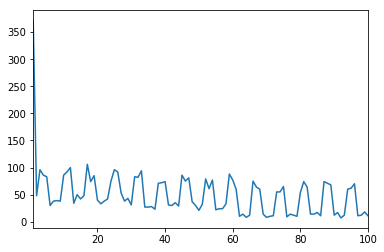

In [25]:
family_data['choice_0'].value_counts().sort_index().plot()

# Globals

In [111]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

days = list(range(N_DAYS, 0, -1))
choice_dict = family_data[[f'choice_{i}' for i in range(10)]].to_dict()
family_size_dict = family_data[['n_people']].to_dict()['n_people']

OUT_PATH = './submission.csv'
submission = pd.read_csv(OUT_PATH, index_col='family_id')

# Cost Function

In [112]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [114]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)
print(start_score)

new = best.copy()
# loop over each family

i=0

for fam_id, _ in enumerate(best):
    i+=1
    if i%500==0:
        print(i)
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)
            print(start_score)
            
submission['assigned_day'] = new
score = cost_function(new)
print(score)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')
            

80240.52457216308
80238.42233600059
80237.31060386158
80237.04902435504
500
80236.79587433841
80232.70838743255
1000
1500
80230.84460567606
2000
2500
3000
80224.57774198786
3500
80220.83397629422
4000
80208.27707354112
4500
5000
80208.27707354112
Score: 80208.27707354112


# Pytorch Approach

In [101]:
import numpy as np
import pandas as pd
from pathlib import Path
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numba import njit
MAX_CHOICE=5


In [102]:
root_path = './santa-workshop-tour-2019/'
best_submit_path='./'

In [103]:
fpath = root_path + 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = root_path + 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [104]:
dummies = []
for i in range(MAX_CHOICE):
    dummies.append((pd.get_dummies(data[f'choice_{i}']).values*data['n_people'].values.astype(np.int8).reshape(-1,1)).reshape(5000, 100, 1))
dummies = np.concatenate(dummies, axis=2)
dummies = np.swapaxes(dummies, 1, 2)

penalties = {n: [0, 50, 50 + 9 * n, 100 + 9 * n, 200 + 9 * n, 200 + 18 * n, 300 + 18 * n, 300 + 36 * n, 400 + 36 * n, 500 + 36 * n + 199 * n] for n in np.unique(data['n_people'])}

mat = []
for i in range(5000):
    n = data.iloc[i]['n_people']
    mat.append(penalties[n][:MAX_CHOICE])
mat = np.array(mat)

initial_sub = pd.read_csv(best_submit_path+'submission.csv')
fam_choices = data
a = pd.merge(initial_sub, fam_choices, on='family_id')
    
initial_choices = []
for i in range(MAX_CHOICE):
    initial_choices.append(((a[f'choice_{i}'] == a['assigned_day'])).values.reshape(-1,1))
initial_choices = np.concatenate(initial_choices, axis=1)
initial_choices = torch.tensor(
   initial_choices*10
    , dtype=torch.float32)#.cuda()

In [105]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

family_size_ls = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
    n: [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(max(family_size_dict.values())+1)
} 

def cost_function(prediction):
    penalty = 0
    violations = 0
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, d, choice in zip(family_size_ls, prediction, choice_dict_num):
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            violations += 1
#             penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    return penalty, accounting_cost, violations

In [106]:
cost_function(initial_sub['assigned_day'].values)

(75461, 5520.488260095933, 0)

In [107]:
class Model(nn.Module):
    def __init__(self, mat, dummies):
        super().__init__()
        self.mat = torch.from_numpy(mat).type(torch.float32)#.cuda()
        self.dummies = torch.from_numpy(dummies).type(torch.float32)#.cuda()
        self.weight = torch.nn.Parameter(data=torch.Tensor(5000, MAX_CHOICE)#.cuda()
                                         , requires_grad=True)
        self.weight.data.copy_(initial_choices)
        
    def forward(self):
        prob = F.softmax(self.weight,dim=1)
        
        x = (prob * self.mat).sum()
        
        daily_occupancy = torch.zeros(100, dtype=torch.float32)#.cuda()
        for i in range(5000):
            daily_occupancy += prob[i]@self.dummies[i]
        diff = torch.cat([torch.abs(daily_occupancy[:-1] - daily_occupancy[1:]), torch.Tensor([0])])
        y = ( torch.relu(daily_occupancy-125.0) / 400.0 * daily_occupancy**(0.5 + diff / 50.0)).sum() 
        
        v = (torch.relu(125-daily_occupancy)**2+torch.relu(daily_occupancy-300)**2).sum()
            
        return  x, y, v*10000

In [108]:
model = Model(mat, dummies)
best_score = 10e10
best_pos = None
optimizer = torch.optim.Adam(model.parameters(), lr = 1)

In [109]:
for epoch in tqdm.tqdm_notebook(range(100)):
    optimizer.zero_grad()
    x, y, v= model()
    loss = x + y + v
    loss.backward()
    optimizer.step()
    
    if epoch % 1 == 0:
        pos = model.weight.argmax(1).cpu().numpy()
        pred = []
        for i in range(5000):
            pred.append(data.iloc[i][f'choice_{pos[i]}'])
        pred = np.array(pred)
        a, b, v = cost_function(pred)
        score = a + b
        if (score < best_score) and v == 0:
            best_score = score
            best_pos = pred
            print(best_score)
            submission['assigned_day'] = best_pos
            submission.to_csv(f'submission.csv')

        x = np.round(x.item(),1)
        y = np.round(y.item(),1)
        print(f'{epoch}\t{x}\t{y}    \t{np.round(score)}   \t{a}\t{np.round(b)}\t{v}')

80981.48826009594
0	75560.5	5532.5    	80981.0   	75461	5520.0	0
1	75513.1	5537.0    	80981.0   	75461	5520.0	0
2	75554.2	5418.9    	80981.0   	75461	5520.0	0
3	75651.7	5352.7    	80981.0   	75461	5520.0	0
4	75515.5	5364.0    	80981.0   	75461	5520.0	0
5	75494.4	5397.6    	80981.0   	75461	5520.0	0
80945.70732175025
6	75479.6	5385.2    	80946.0   	75547	5399.0	0
7	75504.0	5370.5    	80946.0   	75547	5399.0	0
8	75496.7	5391.4    	80946.0   	75547	5399.0	0
9	75618.0	5256.0    	80946.0   	75547	5399.0	0
10	75564.7	5238.9    	80912.0   	75470	5442.0	1
11	75529.7	5205.9    	80968.0   	75615	5353.0	1
12	75523.8	5143.4    	80748.0   	75351	5397.0	1
13	75411.0	5195.6    	80776.0   	75196	5580.0	1
14	75342.5	5216.5    	80705.0   	75278	5427.0	1
15	75248.6	5254.3    	80668.0   	74974	5694.0	1
80536.11997478685
16	75188.8	5290.2    	80536.0   	75365	5171.0	0
17	75240.8	5217.4    	80583.0   	75220	5363.0	0
18	75239.9	5192.2    	80616.0   	75166	5450.0	0
19	75217.8	5198.7    	80584.0   	75366	5218.

164	75081.2	5173.1    	80331.0   	75089	5242.0	0
165	75076.7	5177.5    	80331.0   	75089	5242.0	0
166	75077.1	5177.1    	80331.0   	75089	5242.0	0
167	75095.0	5159.7    	80334.0   	75139	5195.0	0
168	75082.2	5171.9    	80340.0   	75062	5278.0	1
169	75036.6	5221.0    	80340.0   	75189	5151.0	0
170	75101.8	5153.5    	80340.0   	75189	5151.0	0
171	75118.7	5138.5    	80334.0   	75139	5195.0	0
172	75089.9	5165.4    	80344.0   	75039	5305.0	0
173	75076.0	5179.7    	80326.0   	75039	5287.0	0
174	75064.4	5191.7    	80329.0   	75175	5154.0	0
175	75085.2	5169.4    	80329.0   	75175	5154.0	0
176	75102.9	5151.9    	80329.0   	75175	5154.0	0
177	75099.5	5156.3    	80329.0   	75175	5154.0	0
178	75107.9	5147.8    	80331.0   	75089	5242.0	0
179	75080.1	5175.3    	80331.0   	75089	5242.0	0
180	75070.1	5185.2    	80331.0   	75089	5242.0	0
181	75077.9	5177.8    	80339.0   	75003	5336.0	0
182	75075.6	5179.3    	80339.0   	75003	5336.0	0
183	75078.6	5176.4    	80337.0   	75089	5248.0	0
184	75090.6	5164.5  

331	75102.8	5143.7    	80331.0   	75089	5242.0	0
332	75098.8	5147.7    	80331.0   	75089	5242.0	0
333	75090.3	5156.0    	80331.0   	75089	5242.0	0
334	75095.6	5151.0    	80331.0   	75089	5242.0	0
335	75091.3	5155.1    	80331.0   	75089	5242.0	0
336	75097.6	5148.7    	80331.0   	75089	5242.0	0
337	75091.9	5154.4    	80331.0   	75089	5242.0	0
338	75092.4	5154.2    	80331.0   	75089	5242.0	0
339	75084.6	5161.6    	80331.0   	75089	5242.0	0
340	75092.4	5153.9    	80331.0   	75089	5242.0	0
341	75094.1	5152.1    	80331.0   	75089	5242.0	0
342	75091.7	5154.7    	80331.0   	75089	5242.0	0
343	75100.2	5146.0    	80331.0   	75089	5242.0	0
344	75107.0	5139.5    	80331.0   	75089	5242.0	0
345	75092.4	5153.9    	80331.0   	75089	5242.0	0
346	75092.9	5153.1    	80331.0   	75089	5242.0	0
347	75090.7	5155.4    	80331.0   	75089	5242.0	0
348	75086.7	5159.3    	80331.0   	75089	5242.0	0
349	75098.4	5147.5    	80331.0   	75089	5242.0	0
350	75097.0	5148.6    	80331.0   	75089	5242.0	0


KeyboardInterrupt: 

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
fpath = root_path + 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = root_path + 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [116]:
family_size_dict = data[['n_people']].to_dict()['n_people']
m,_ = data.shape 

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [117]:
def weekday(days):
    weekday = []
    for day in days:
        if day%7==2:
            weekday.append('Monday')
        elif day%7==1:
            weekday.append('Tuesday')
        elif day%7==0:
            weekday.append('Wednesday')
        elif day%7==6:
            weekday.append('Thursday')
        elif day%7==5:
            weekday.append('Friday')
        elif day%7==4:
            weekday.append('Saturday')
        else:
            weekday.append('Sunday')
    return weekday
weekday_list = [weekday(data[cols].values[i][:].tolist()) for i in range(5000)]
weekday_list = pd.DataFrame(weekday_list,columns = ['weekday_'+cols[i] for i in range(10)])
weekday_list

,weekday_choice_0,weekday_choice_1,weekday_choice_2,weekday_choice_3,weekday_choice_4,weekday_choice_5,weekday_choice_6,weekday_choice_7,weekday_choice_8,weekday_choice_9
0,Sunday,Sunday,Friday,Friday,Friday,Friday,Tuesday,Thursday,Sunday,Wednesday
1,Friday,Saturday,Friday,Friday,Saturday,Friday,Sunday,Thursday,Sunday,Friday
2,Monday,Friday,Saturday,Friday,Thursday,Friday,Sunday,Friday,Sunday,Friday
3,Monday,Saturday,Tuesday,Friday,Saturday,Thursday,Friday,Sunday,Monday,Sunday
4,Saturday,Tuesday,Friday,Monday,Friday,Sunday,Saturday,Monday,Wednesday,Saturday
5,Saturday,Sunday,Friday,Sunday,Saturday,Friday,Wednesday,Tuesday,Friday,Monday
6,Saturday,Saturday,Tuesday,Sunday,Wednesday,Saturday,Saturday,Tuesday,Wednesday,Tuesday
7,Saturday,Saturday,Sunday,Thursday,Sunday,Sunday,Saturday,Tuesday,Saturday,Sunday
8,Saturday,Saturday,Tuesday,Friday,Friday,Friday,Monday,Sunday,Saturday,Saturday
9,Tuesday,Saturday,Saturday,Tuesday,Friday,Saturday,Friday,Friday,Saturday,Wednesday


The mean number of difficult days per family is: 7.1552
Standard deviation of difficult days is: 1.371682528867372


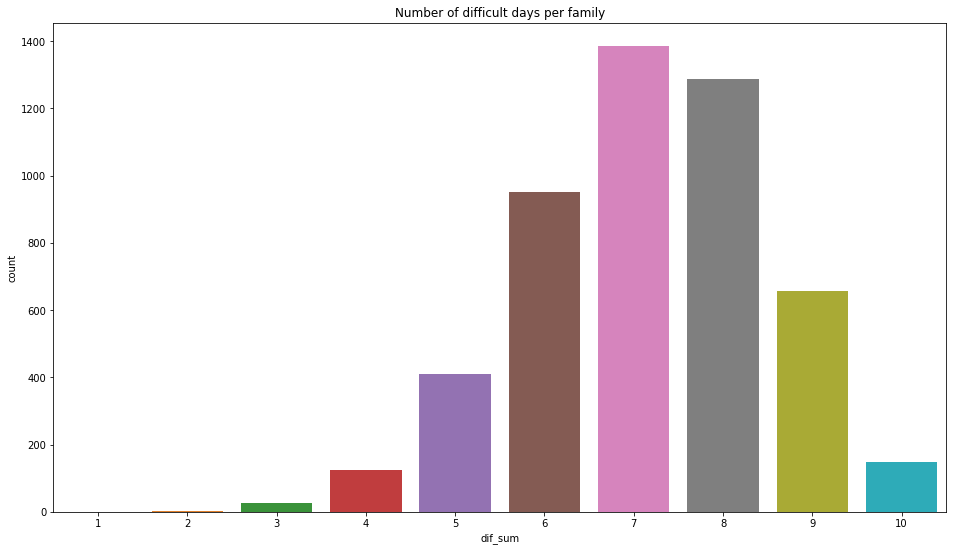

In [118]:
def difficulty(days):
    dif = []
    for day in days:
        wd = weekday([day])
        if day == 1 or day == 2 or day == 3:
            dif.append(1)
        elif wd[0]=='Monday' or wd[0]=='Tuesday' or wd[0]=='Wednesday' or wd[0]=='Thursday':
            dif.append(0)
        else:
            dif.append(1)
    return dif

dif_list = [difficulty(data[cols].values[i][:].tolist()) for i in range(5000)]
dif_list = pd.DataFrame(dif_list,columns = ['difficulty_'+cols[i] for i in range(10)])
dif_sum = pd.DataFrame(np.sum(dif_list,axis=1),columns=['dif_sum'])
#data = pd.concat([data,dif_sum],axis=1)
plt.figure(figsize=(16,9))
sns.countplot(dif_sum['dif_sum'])
plt.title("Number of difficult days per family")
print("The mean number of difficult days per family is: {}".format(np.mean(dif_sum['dif_sum'])))
print("Standard deviation of difficult days is: {}".format(np.std(dif_sum['dif_sum'])))

In [119]:
family_size = list(range(2,9))
cost_per_family_size = np.zeros((11,len(family_size)))
def choice_cost(n,choice):
    if choice == 0:
        return 0
    elif choice == 1:
        return 50
    elif choice == 2:
        return 50 + 9 * n
    elif choice == 3:
        return 100 + 9 * n
    elif choice == 4:
        return 200 + 9 * n
    elif choice == 5:
        return 200 + 18 * n
    elif choice == 6:
        return 300 + 18 * n
    elif choice == 7:
        return 300 + 36 * n
    elif choice == 8:
        return 400 + 36 * n
    elif choice == 9:
        return 500 + 36 * n + 199 * n
    else:
        return 500 + 36 * n + 398 * n
j = 0
for n in family_size:  
    for i in range(11):
        cost_per_family_size[i,j]=choice_cost(n,i)
    j+=1

cost_per_family_size = pd.DataFrame(cost_per_family_size.T,index = [str(x)+'_people' for x in range(2,9)],columns = ['choice_'+str(x) for x in range(11)])
cost_per_family_size['n_people']=list(range(2,9))
cost_per_family_size

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n_people
2_people,0.0,50.0,68.0,118.0,218.0,236.0,336.0,372.0,472.0,970.0,1368.0,2
3_people,0.0,50.0,77.0,127.0,227.0,254.0,354.0,408.0,508.0,1205.0,1802.0,3
4_people,0.0,50.0,86.0,136.0,236.0,272.0,372.0,444.0,544.0,1440.0,2236.0,4
5_people,0.0,50.0,95.0,145.0,245.0,290.0,390.0,480.0,580.0,1675.0,2670.0,5
6_people,0.0,50.0,104.0,154.0,254.0,308.0,408.0,516.0,616.0,1910.0,3104.0,6
7_people,0.0,50.0,113.0,163.0,263.0,326.0,426.0,552.0,652.0,2145.0,3538.0,7
8_people,0.0,50.0,122.0,172.0,272.0,344.0,444.0,588.0,688.0,2380.0,3972.0,8


In [120]:
sorted_families = []
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,3))
for j in range(4):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]

C:\WorkData\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


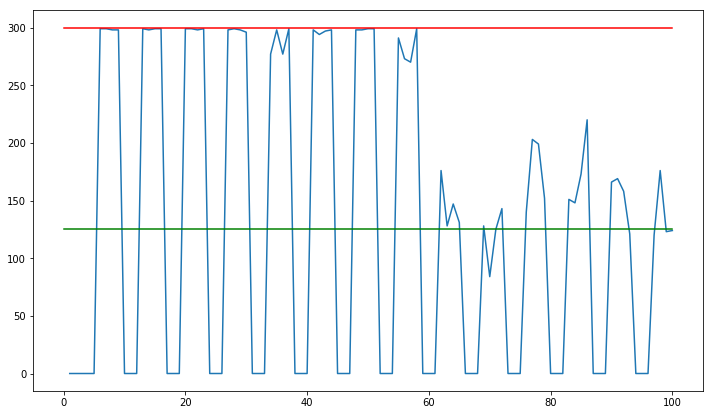

In [121]:
def daily_plot(answer):
    def get_daily_occupancy(answer):
        daily_occupancy={i:0 for i in range(0,101)}
        for i in range(m):
            daily_occupancy[int(answer[i,1])]+=data.loc[i]['n_people']
        return daily_occupancy
    daily_occupancy = get_daily_occupancy(answer)
    plt.figure(figsize=(12,7))
    fig = sns.lineplot(x=list(range(1,101)),y=[daily_occupancy[i] for i in range(1,101)])
    ax = plt.axes()
    x = np.linspace(0, 100, 100)
    y= np.linspace(125,125,100)
    ax.plot(x, y,color='green');
    x = np.linspace(0, 100, 100)
    y= np.linspace(300,300,100)
    ax.plot(x, y,color='red')
daily_plot(answer)

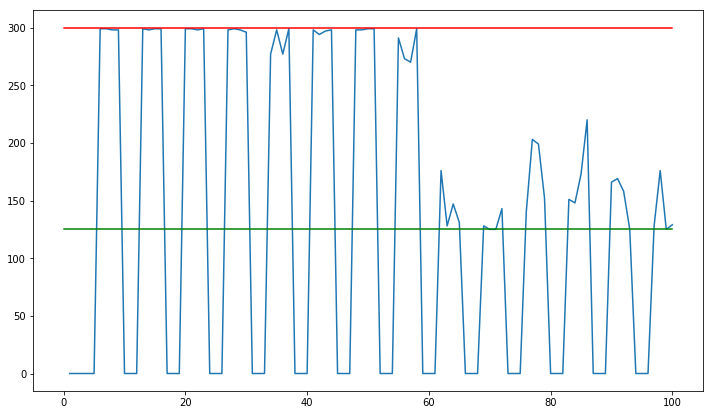

In [122]:
for j in range(4,8):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

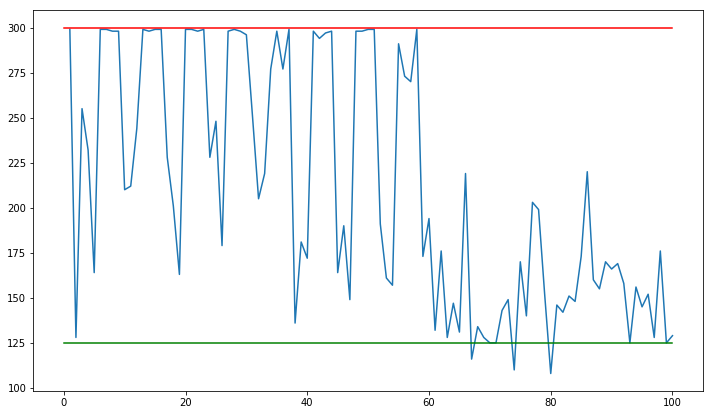

In [123]:
for j in range(4):
    for i in range(m):
        if (difficulty(data.loc[i][['choice_'+str(j)]])==[1] or difficulty(data.loc[i][['choice_'+str(j)]])==[2]) and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

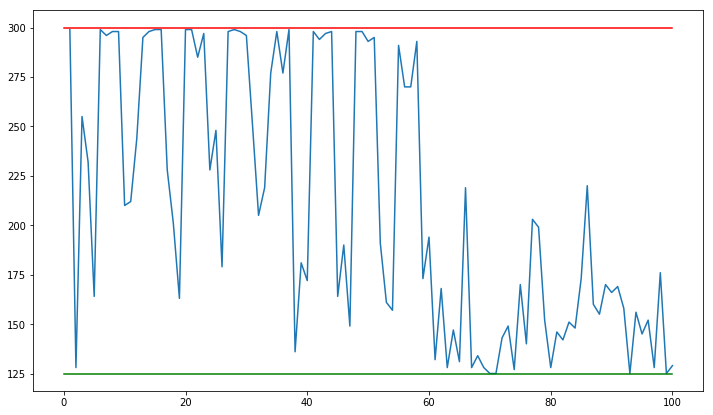

In [124]:
del sorted_families
for k,v in daily_occupancy.items():
    if v<125:
        for j in range(4):
            for i in range(m):
                if daily_occupancy[data.loc[i][['choice_'+str(int(answer[i,2]))]][0]]-data.loc[i][['n_people']][0]>=125 and data.loc[i][['choice_'+str(j)]][0]==k and daily_occupancy[k]<=125:
                    answer[i,0]=i
                    answer[i,1]=data.loc[i][['choice_'+str(j)]]
                    answer[i,2]=j
                    daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

C:\WorkData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


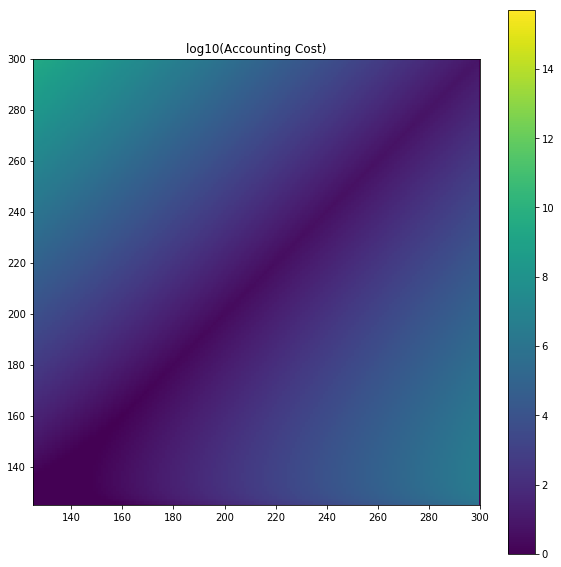

In [125]:
def accounting(today,yesterday):
    return max(0, (today-125.0) / 400.0 * today**(0.5 + abs(today-yesterday) / 50.0))
acc_matrix = np.zeros((301,301))
for i, x in enumerate(range(1,300+1)):
    for j, y in enumerate(range(1,300+1)):
        acc_matrix[i,j] = np.log10(accounting(x,y))
        
plt.figure(figsize=(10,10))
plt.imshow(np.clip(acc_matrix, 0, 4000))
plt.xlim(125,300)
plt.ylim(125,300)
plt.title('log10(Accounting Cost)')
plt.colorbar()

In [126]:
import numpy as np
import pandas as pd
from numba import njit, prange

family_size = data.n_people.values.astype(np.int8)

penalties = np.asarray([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ] for n in range(family_size.max() + 1)
])
family_cost_matrix = np.concatenate(data.n_people.apply(lambda n: np.repeat(penalties[n, 10], 100).reshape(1, 100)))
for fam in data.index:
    for choice_order, day in enumerate(data.loc[fam].drop("n_people")):
        family_cost_matrix[fam, day - 1] = penalties[data.loc[fam, "n_people"], choice_order]
accounting_cost_matrix = np.zeros((500, 500))
for n in range(accounting_cost_matrix.shape[0]):
    for diff in range(accounting_cost_matrix.shape[1]):
        accounting_cost_matrix[n, diff] = max(0, (n - 125.0) / 400.0 * n**(0.5 + diff / 50.0))

In [127]:
@njit(fastmath=True)
def cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix):
    N_DAYS = family_cost_matrix.shape[1]
    MAX_OCCUPANCY = 300
    MIN_OCCUPANCY = 125
    penalty = 0
    daily_occupancy = np.zeros(N_DAYS + 1, dtype=np.int16)
    for i, (pred, n) in enumerate(zip(prediction, family_size)):
        daily_occupancy[pred - 1] += n
        penalty += family_cost_matrix[i, pred - 1]

    accounting_cost = 0
    n_low = 0
    n_high = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_next = daily_occupancy[day + 1]
        n = daily_occupancy[day]
        n_high += (n > MAX_OCCUPANCY) 
        n_low += (n < MIN_OCCUPANCY)
        diff = abs(n - n_next)
        accounting_cost += accounting_cost_matrix[n, diff]

    return np.asarray([penalty, accounting_cost, n_low, n_high])

In [128]:
def get_cost_consolidated(prediction): 
    fc, ac, l, h = cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix)
    return (fc + ac) + (l + h) * 10000000
print(get_cost_consolidated(answer[:,1].astype(np.int8)))

3134536074.777665


(125, 300)

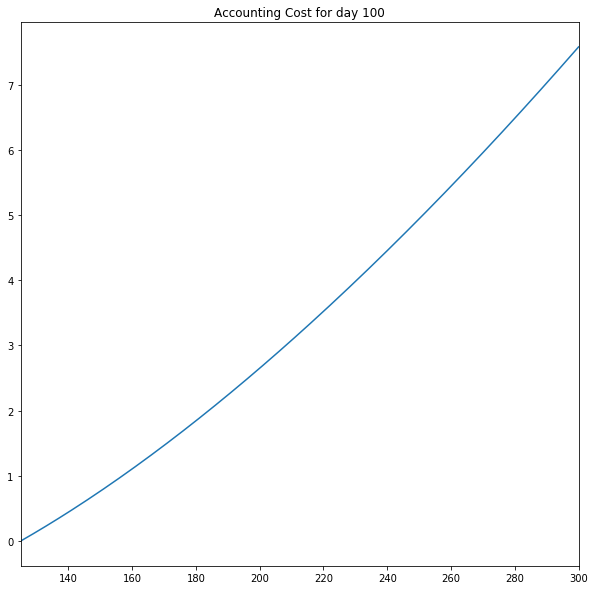

In [129]:
acc_day100 = np.zeros((300,1))
for i, x in enumerate(range(1,300+1)):
    acc_day100[i] = accounting(x,x)
plt.figure(figsize=(10,10))
sns.lineplot(x=[i for i in range(1,301)],y=acc_day100[:,0])
plt.title('Accounting Cost for day 100')
plt.xlim(125,300)

In [130]:
n = 0
for i in range(m):
    n+=data.loc[i][['n_people']][0]
print(str(n)+" total people to visit Santa")

21003 total people to visit Santa


100 0
100 1
100 2
100 3
99 0
99 1
99 2
99 3
98 0
98 1
98 2
98 3
97 0
97 1
97 2
97 3
96 0
96 1
96 2
96 3
95 0
95 1
95 2
95 3
94 0
94 1
94 2
94 3
93 0
93 1
93 2
93 3
92 0
92 1
92 2
92 3
91 0
91 1
91 2
91 3
90 0
90 1
90 2
90 3
89 0
89 1
89 2
89 3
88 0
88 1
88 2
88 3
87 0
87 1
87 2
87 3
86 0
86 1
86 2
86 3
85 0
85 1
85 2
85 3
84 0
84 1
84 2
84 3
83 0
83 1
83 2
83 3
82 0
82 1
82 2
82 3
81 0
81 1
81 2
81 3
80 0
80 1
80 2
80 3
79 0
79 1
79 2
79 3
78 0
78 1
78 2
78 3
77 0
77 1
77 2
77 3
76 0
76 1
76 2
76 3
75 0
75 1
75 2
75 3
74 0
74 1
74 2
74 3
73 0
73 1
73 2
73 3
72 0
72 1
72 2
72 3
71 0
71 1
71 2
71 3
70 0
70 1
70 2
70 3
69 0
69 1
69 2
69 3
68 0
68 1
68 2
68 3
67 0
67 1
67 2
67 3
66 0
66 1
66 2
66 3
65 0
65 1
65 2
65 3
64 0
64 1
64 2
64 3
63 0
63 1
63 2
63 3
62 0
62 1
62 2
62 3
61 0
61 1
61 2
61 3
60 0
60 1
60 2
60 3
59 0
59 1
59 2
59 3
58 0
58 1
58 2
58 3
57 0
57 1
57 2
57 3
56 0
56 1
56 2
56 3
55 0
55 1
55 2
55 3
54 0
54 1
54 2
54 3
53 0
53 1
53 2
53 3
52 0
52 1
52 2
52 3
51 0
51 1
51 2
5

C:\WorkData\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


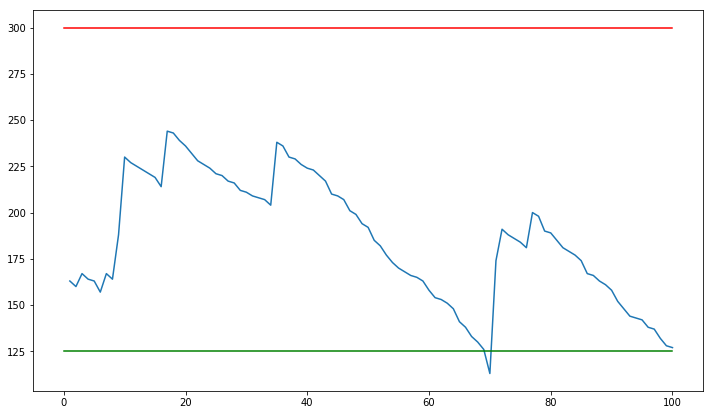

In [132]:
sorted_families = {i:0 for i in range(m)}
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,2))
prev_day = 125
diff = 1
factor = 7
for day in days:
    for choice in range(4):
        print(day, choice)
        for i in range(m):
            if data.loc[i][['choice_'+str(choice)]][0]==day and sorted_families[i]==0:
                if daily_occupancy[day]+data.loc[i][['n_people']][0]<=300:
                    if daily_occupancy[day]-prev_day<diff and daily_occupancy[day]-prev_day<diff*factor:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[day]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
    prev_day = daily_occupancy[day]
daily_plot(answer)

4433 0
4433 1
4433 2
4433 3
4433 4
4433 5
4433 6
4433 7
4433 8
1# iteration -> 4464 families sorted with a combined cost of 1355391.5029881669
4464 0
4464 1
4464 2
4464 3
4464 4
4464 5
4464 6
4464 7
4464 8
2# iteration -> 4599 families sorted with a combined cost of 1062949.5628151936
4599 0
4599 1
4599 2
4599 3
4599 4
4599 5
4599 6
4599 7
4599 8
3# iteration -> 4712 families sorted with a combined cost of 818252.1514330058
4712 0
4712 1
4712 2
4712 3
4712 4
4712 5
4712 6
4712 7
4712 8
4# iteration -> 4811 families sorted with a combined cost of 606774.8686559763
4811 0
4811 1
4811 2
4811 3
4811 4
4811 5
4811 6
4811 7
4811 8
5# iteration -> 4894 families sorted with a combined cost of 441512.50115352054
4894 0
4894 1
4894 2
4894 3
4894 4
4894 5
4894 6
4894 7
4894 8
6# iteration -> 4965 families sorted with a combined cost of 321620.89846794214
4965 0
4965 1
4965 2
4965 3
4965 4
4965 5
4965 6
4965 7
4965 8
7# iteration -> 4996 families sorted with a combined cost of 252192.99033675506
4

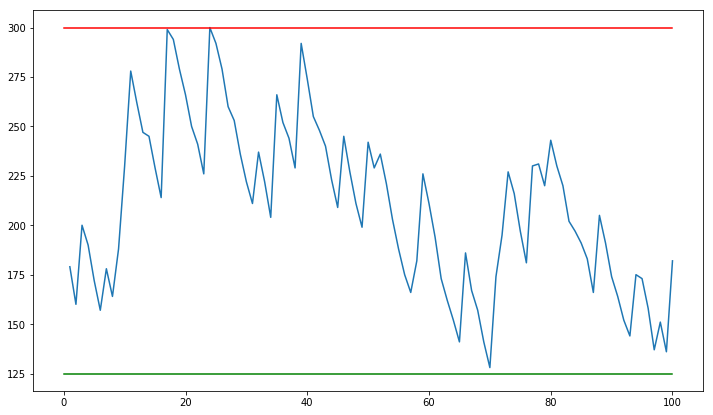

In [134]:
diff_normalizer = 1
diff = 2
count=sum([sorted_families[i]==1 for i in range(m)])
while count<m:
    daily_occupancy[101]=daily_occupancy[100]
    for j in range(9):
        print(count, j)
        for i in range(m):
            daily_occupancy[101]=daily_occupancy[100]
            if sorted_families[i]==0:
                if daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<=300:
                    if abs(daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]-daily_occupancy[data.loc[i][['choice_'+str(j)]][0]+1])<diff_normalizer*diff:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
    count=sum([sorted_families[i]==1 for i in range(m)])
    print("{}# iteration -> {} families sorted with a combined cost of {}".format(diff_normalizer,count,get_cost_consolidated(answer[:,1].astype(np.int8))))
    diff_normalizer+=1
daily_plot(answer)

In [139]:
import tqdm
def optimize(answer,n_iter=100,verbose=5,print_ = False,rd_seed=23):
    import random
    try:
        new_answer=answer[:,1].copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    except IndexError:
        new_answer=answer.copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    if print_:
        print('Start score: {}'.format(best_score))
    start_score = best_score
    random.seed(rd_seed)
    family_list = list(range(m))
    for n in tqdm.tqdm_notebook(range(n_iter)):
        random.shuffle(days)
        random.shuffle(family_list)
        for day in days:
            for i in family_list:
                aux = new_answer[i]
                new_answer[i]=day
                new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
                if new_score<=best_score:
                    try:
                        answer[i,1]=day
                    except:
                        answer[i]=day
                    best_score = new_score
                else:
                    new_answer[i]=aux
        if not best_score == start_score:
            start_score = best_score
        else:
            print("{}# early stopping best score: {}".format(n+1,best_score))
            break
        if (n+1)%verbose==0 and print_:
            print("{}# best score: {}".format(n+1,best_score))
    return answer


In [140]:
def find_seed(answer):
    start_answer = answer.copy()
    best_score = get_cost_consolidated(answer[:,1].astype(np.int8))
    best = 0
    for i in range(1000):
        new_answer = optimize(start_answer[:,1].copy(),n_iter=2000,verbose=5,print_=False,rd_seed = i)
        new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
        if new_score<best_score:
            best_score = new_score
            best = i
            print(best)
    return best

In [142]:

answer

array([[0.000e+00, 5.200e+01],
       [1.000e+00, 2.600e+01],
       [2.000e+00, 1.000e+02],
       ...,
       [4.997e+03, 3.200e+01],
       [4.998e+03, 9.200e+01],
       [4.999e+03, 1.300e+01]])

In [145]:
import pandas as pd
answer_new = np.array(pd.read_csv('submission.csv'), float)

In [146]:
answer_new


array([[0.000e+00, 5.200e+01],
       [1.000e+00, 2.600e+01],
       [2.000e+00, 1.000e+02],
       ...,
       [4.997e+03, 3.200e+01],
       [4.998e+03, 9.200e+01],
       [4.999e+03, 1.300e+01]])

In [147]:
answer = optimize(answer_new,n_iter=200,verbose=5,print_=True,rd_seed=23)

Start score: 79893.50966664156


4# early stopping best score: 79802.64008833977


79802.64008833977

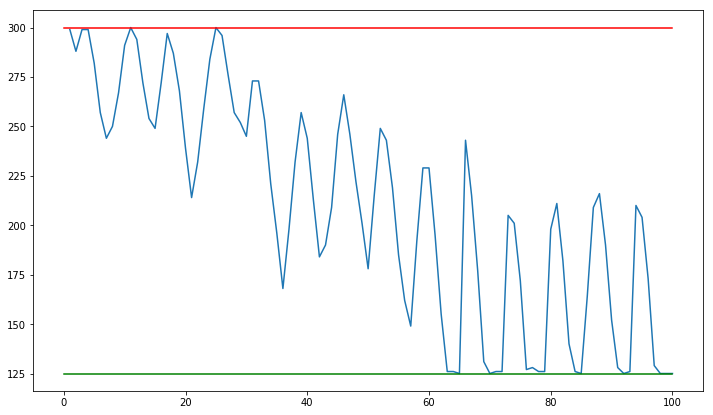

In [148]:
daily_plot(answer)
get_cost_consolidated(answer[:,1].astype(np.int8))

In [150]:
from itertools import product
from tqdm import tqdm_notebook as tqdm
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
def stochastic_product_search(top_k, fam_size, original, choice_matrix, 
                              disable_tqdm=False, verbose=10000,
                              n_iter=500, random_state=2019):
    """
    original (np.array): The original day assignments.
    
    At every iterations, randomly sample fam_size families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^fam_size products.
    """
    
    best = original.copy()
    best_score = get_cost_consolidated(best)
    
    np.random.seed(random_state)

    for i in tqdm(range(n_iter), disable=disable_tqdm):
        fam_indices = np.random.choice(range(choice_matrix.shape[0]), size=fam_size)
        changes = np.array(list(product(*choice_matrix[fam_indices, :top_k].tolist())))

        for change in changes:
            new = best.copy()
            new[fam_indices] = change

            new_score = get_cost_consolidated(new)

            if new_score < best_score:
                best_score = new_score
                best = new
        
        if new_score < best_score:
            best_score = new_score
            best = new
    
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}")
    
    print(f"Final best score is {best_score:.2f}")
    return best

final = stochastic_product_search(
        top_k=4,
        fam_size=3, 
        original=answer[:,1].astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=1000000,
        verbose=50000,
        )

Iteration #0: Best score is 79802.64
Iteration #50000: Best score is 78603.27
Iteration #100000: Best score is 78152.64
Iteration #150000: Best score is 77335.21
Iteration #200000: Best score is 77260.33
Iteration #250000: Best score is 77130.11
Iteration #300000: Best score is 76845.85
Iteration #350000: Best score is 76785.18
Iteration #400000: Best score is 76663.59
Iteration #450000: Best score is 76422.66
Iteration #500000: Best score is 76343.78
Iteration #550000: Best score is 76058.70
Iteration #600000: Best score is 75864.91
Iteration #650000: Best score is 75584.08
Iteration #700000: Best score is 75509.17
Iteration #750000: Best score is 75324.81
Iteration #800000: Best score is 75270.96
Iteration #850000: Best score is 75205.16
Iteration #900000: Best score is 75121.41
Iteration #950000: Best score is 75098.63
Final best score is 75079.79


In [ ]:
aux = np.zeros((m,2))
aux[:,1]=final
final = stochastic_product_search(
        top_k=4,
        fam_size=5, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=250000,
        verbose=5000,
        )
daily_plot(aux)

Iteration #0: Best score is 75079.79
Iteration #5000: Best score is 75079.79
Iteration #10000: Best score is 75079.79
Iteration #15000: Best score is 75055.68
Iteration #20000: Best score is 75038.43
Iteration #25000: Best score is 75016.01
Iteration #30000: Best score is 75016.01
Iteration #35000: Best score is 75016.01
Iteration #40000: Best score is 75016.01
Iteration #45000: Best score is 75011.72
Iteration #50000: Best score is 75011.72
Iteration #55000: Best score is 75011.72
Iteration #60000: Best score is 75011.72
Iteration #65000: Best score is 75011.72


In [ ]:
final = stochastic_product_search(
        top_k=3,
        fam_size=8, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=40000,
        verbose=5000,
        )
aux = np.zeros((m,2))
aux[:,1]=final
daily_plot(aux)

In [152]:
prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)